In [1]:
!date

Sun Feb 23 16:58:29 PST 2020


# Level 2 Plotting

In [420]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")
gene =    anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Examples
- Gcsh, L2/3 IT
- Alkbh5 L5 ET
- Snrpn L5 ET
- Fam19a5 L5 IT
- Plcxd3 L5 IT
- Glb1 (check it out)
- Cenpq, L2/3 IT
- Pxmp4 L5/6 NP
- Maip1 L5/6 NP
- Lhfpl4 L5/6 NP
- Plekha3 L5/6 NP
- Cenpw L5/6 NP
- Atp6v0e L5/6 NP
- Acbd3 L6 CT
- Rilpl2 L6 CT
- Clic4 L6 CT
- Plekha3 Pvalb
- Tmem41a PValb
- Kbtbd3 Pvalb
- Wwp1 Pvalb (good one)
- Gnal Pvalb (good one)
- Eif4ebp1 Pvalb
- Fam19a5 Vip (good one)
- Gnal Sst
- Sgpp1 Sst
- Asic2 Sst (good one)
- 


In [921]:
specific_gene = "Fam19a5" # Slfn3 from cnum 2 Fam19a5 Plcxd3
specific_cluster = "Vip"

assignments = isoform.obs.subclass_label.values
unique = np.unique(assignments)
cidx =np.where(unique == specific_cluster)[0][0]

gene_exp = np.asarray(gene[:, gene.var["gene_name"] == specific_gene].layers["log1p"]).reshape(-1)
isof_exp = np.asarray(isoform[:, isoform.var["gene_name"] == specific_gene].layers["log1p"].todense())

In [922]:
ratio =  np.zeros((2, 2))
sem =  np.zeros((2, 2))
mask = assignments==specific_cluster
sub_mtx = isof_exp[mask]

L1 = sub_mtx.sum(axis=1)
norm = (sub_mtx/L1[:,None])
norm = norm[~np.isnan(norm[:,0])]

ratio_0 = norm
# sem[0] = stats.sem(norm)

mask = assignments!=c
sub_mtx = isof_exp[mask]

L1 = sub_mtx.sum(axis=1)
norm = (sub_mtx/L1[:,None])
norm = norm[~np.isnan(norm[:,0])]

ratio_1 = norm
# sem[1] = stats.sem(norm)

In [923]:
ratios = [ratio_0[:,1], ratio_1[:,1]]

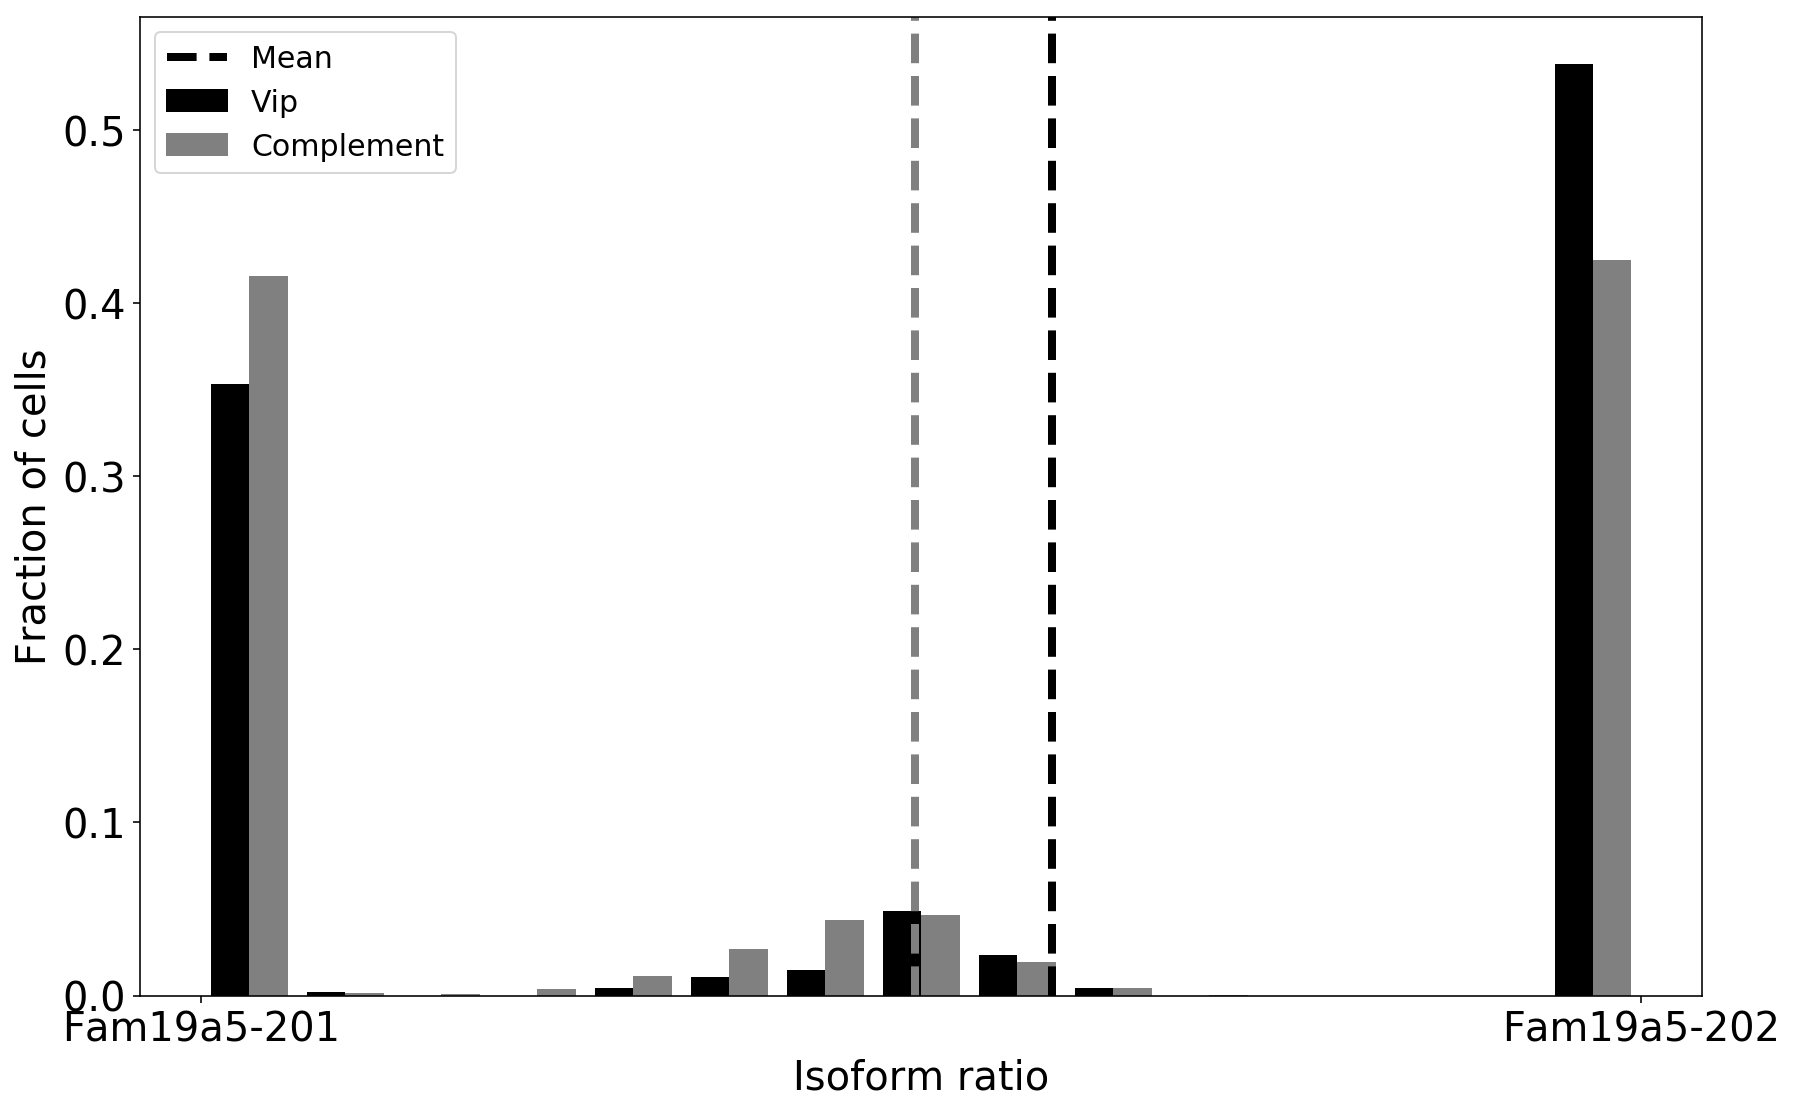

In [924]:
fig, ax = plt.subplots(figsize=(14,9))
fig.subplots_adjust(hspace=0, wspace=0)

cluster_color = "k"
complement_color = "grey"
color = [cluster_color, complement_color]

label =[specific_cluster, "Complement"]

num_bins=15

x = ratios[0]
y = ratios[1]
data = [x, y]

weights1 = np.ones_like(x)/float(len(x))
weights2 = np.ones_like(y)/float(len(y))
weights = [weights1, weights2]

n, bins, patches = ax.hist(data, num_bins, weights=weights, color=color, label=label)
m = ax.axvline(x.mean(), linestyle="--", color=cluster_color, label="Mean", linewidth=4)
ax.axvline(y.mean(), linestyle="--", color=complement_color, label="Mean", linewidth=4)

ax.set_xticks([0,1])
ax.set_xticklabels(["{}-201".format(specific_gene), "{}-202".format(specific_gene)], rotation=0, ha="center")

cluster = mpatches.Patch(color=cluster_color, label=specific_cluster)
complement = mpatches.Patch(color=complement_color, label="Complement")
ax.legend(handles=[m, cluster, complement], fontsize=15)#,loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Isoform ratio")

plt.show()

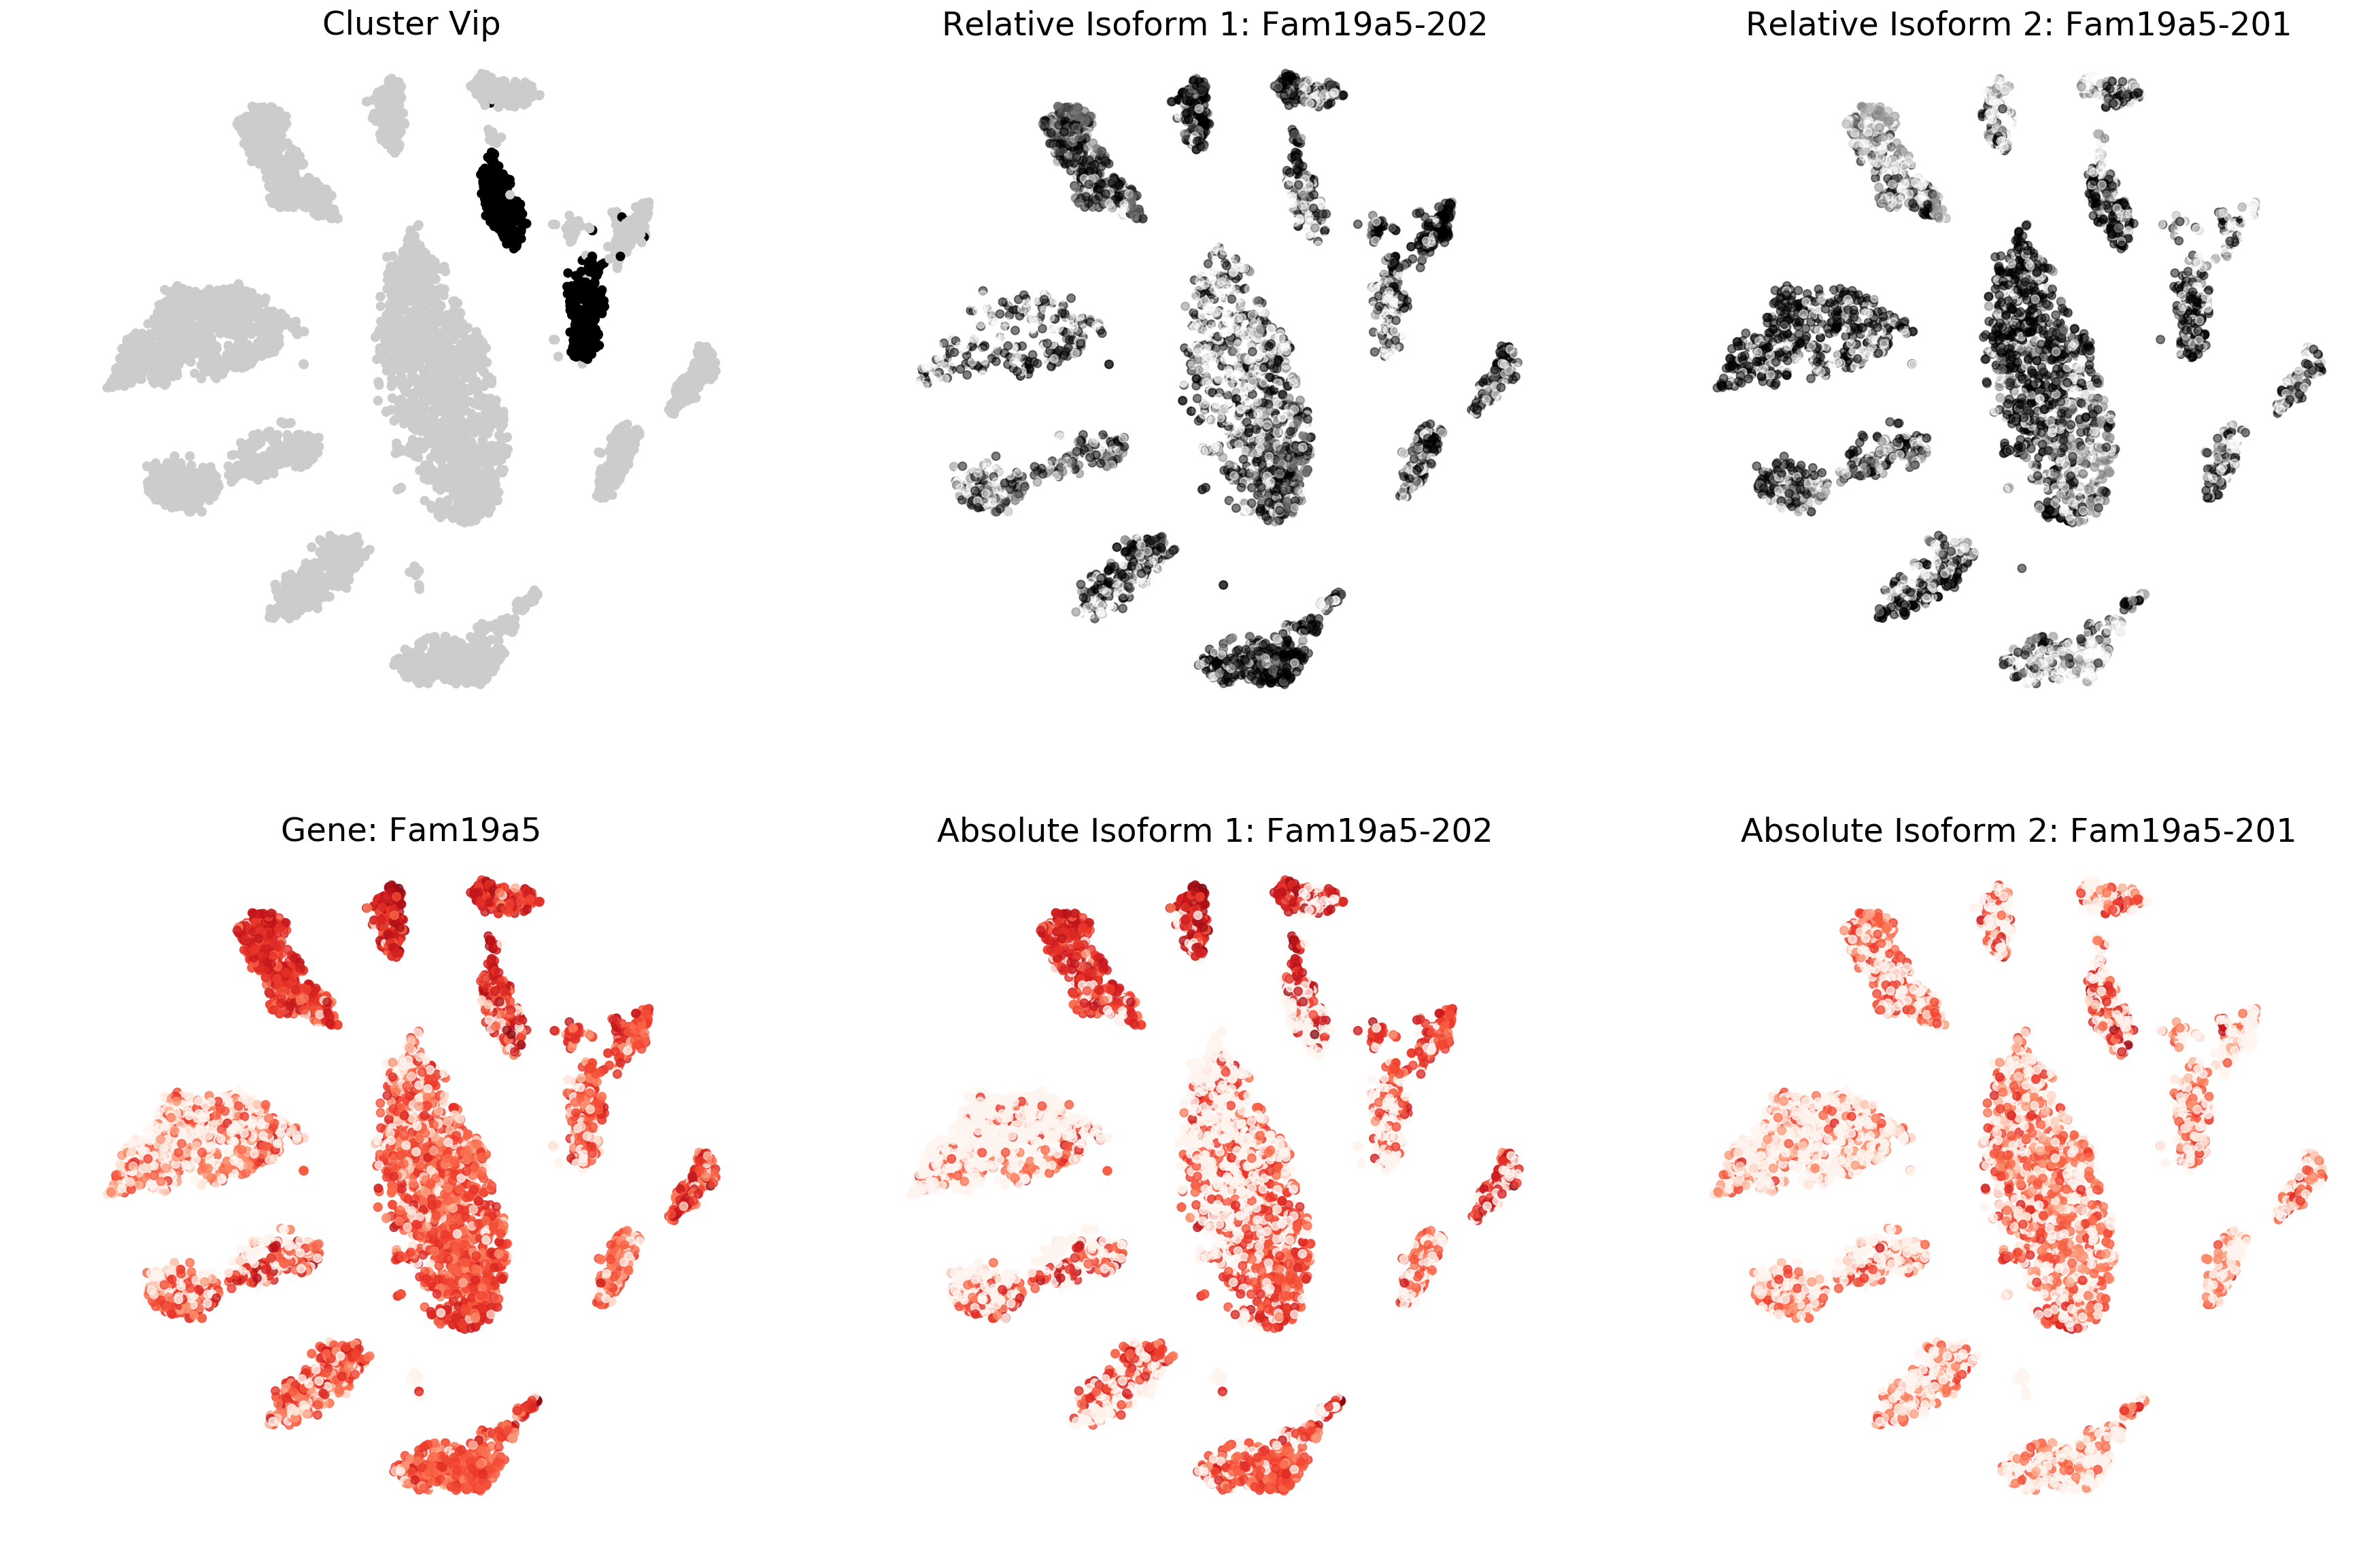

In [925]:
iso_1, iso_2 = isoform[:, isoform.var["gene_name"] == specific_gene].var.transcript_name.values


L1 = isof_exp.sum(axis=1)
norm = (isof_exp/L1[:,None])

fig, ax = plt.subplots(figsize=(30, 20), nrows=2, ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = assignments == specific_cluster
#cells = gene.obs["subclass_label"] == str(cidx)

loc = ax[0,0]
sc = loc.scatter(x, y, c = c, cmap="nipy_spectral_r")
loc.set_axis_off()
loc.set_title("Cluster {}".format(specific_cluster))

# Relative
loc = ax[0, 1]
c = norm[:,0]
idx = ~np.isnan(c)
sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
loc.set_axis_off()
loc.set_title("Relative Isoform 1: "+ iso_1)

loc = ax[0, 2]
c = norm[:,1]
idx = ~np.isnan(c)
sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
loc.set_axis_off()
loc.set_title("Relative Isoform 2: "+ iso_2)



cmap = "Reds"
# Gene Expression
loc = ax[1,0]
sc = loc.scatter(x, y, c = gene_exp, cmap=cmap, alpha=0.75)
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Gene: "+ specific_gene)


## Absolute
loc=ax[1, 1]
sc = loc.scatter(x, y, c = isof_exp[:,0], cmap=cmap, alpha=0.75)
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Absolute Isoform 1: "+ iso_1)



loc=ax[1,2]
sc = loc.scatter(x, y, c = isof_exp[:,1], cmap=cmap, alpha=0.75)

loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Absolute Isoform 2: "+ iso_2)



plt.show()

# At the class level

In [940]:
specific_gene = "Psmg4" # Slfn3 from cnum 2 Fam19a5 Plcxd3
specific_cluster = "Glutamatergic"

assignments = isoform.obs.class_label.values
unique = np.unique(assignments)
cidx =np.where(unique == specific_cluster)[0][0]

gene_exp = np.asarray(gene[:, gene.var["gene_name"] == specific_gene].layers["log1p"]).reshape(-1)
isof_exp = np.asarray(isoform[:, isoform.var["gene_name"] == specific_gene].layers["log1p"].todense())

In [941]:
ratio =  np.zeros((2, 2))
sem =  np.zeros((2, 2))
mask = assignments==specific_cluster
sub_mtx = isof_exp[mask]

L1 = sub_mtx.sum(axis=1)
norm = (sub_mtx/L1[:,None])
norm = norm[~np.isnan(norm[:,0])]

ratio_0 = norm
# sem[0] = stats.sem(norm)

mask = assignments!=c
sub_mtx = isof_exp[mask]

L1 = sub_mtx.sum(axis=1)
norm = (sub_mtx/L1[:,None])
norm = norm[~np.isnan(norm[:,0])]

ratio_1 = norm
# sem[1] = stats.sem(norm)

In [942]:
ratios = [ratio_0[:,1], ratio_1[:,1]]

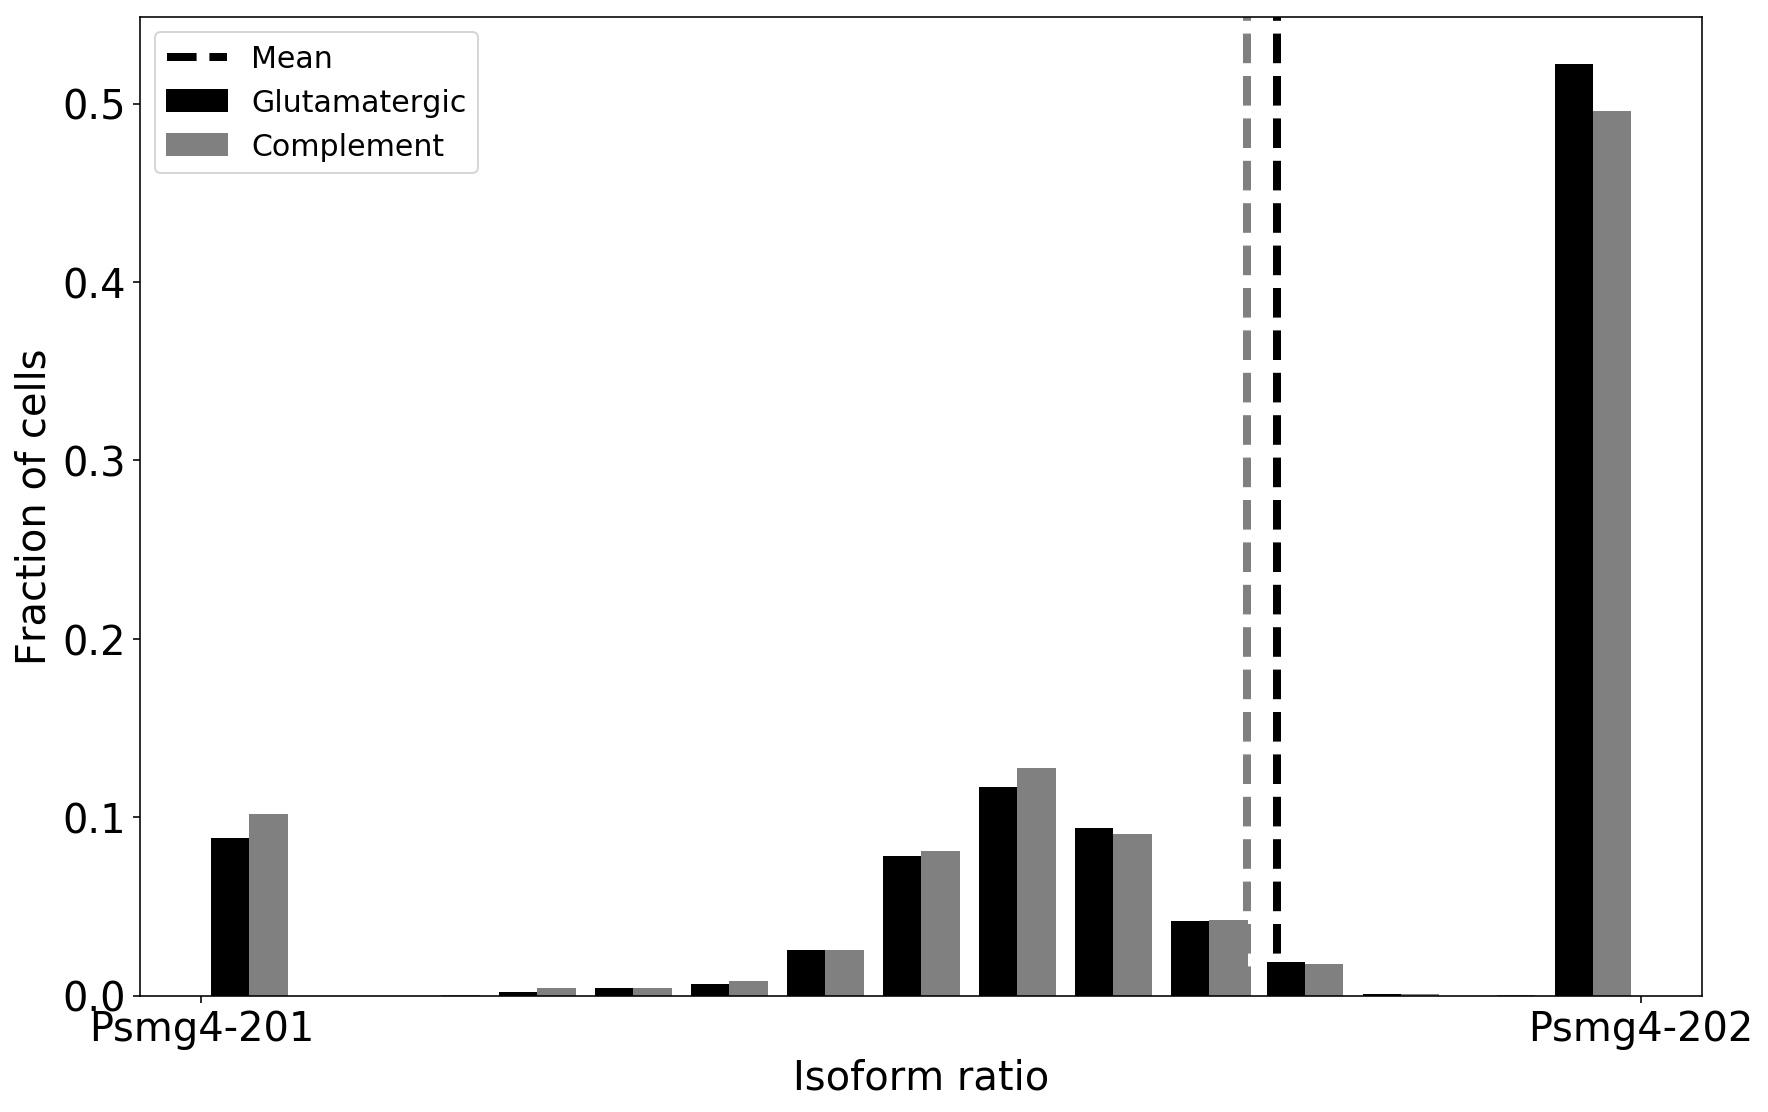

In [943]:
fig, ax = plt.subplots(figsize=(14,9))
fig.subplots_adjust(hspace=0, wspace=0)

cluster_color = "k"
complement_color = "grey"
color = [cluster_color, complement_color]

label =[specific_cluster, "Complement"]

num_bins=15

x = ratios[0]
y = ratios[1]
data = [x, y]

weights1 = np.ones_like(x)/float(len(x))
weights2 = np.ones_like(y)/float(len(y))
weights = [weights1, weights2]

n, bins, patches = ax.hist(data, num_bins, weights=weights, color=color, label=label)
m = ax.axvline(x.mean(), linestyle="--", color=cluster_color, label="Mean", linewidth=4)
ax.axvline(y.mean(), linestyle="--", color=complement_color, label="Mean", linewidth=4)

ax.set_xticks([0,1])
ax.set_xticklabels(["{}-201".format(specific_gene), "{}-202".format(specific_gene)], rotation=0, ha="center")

cluster = mpatches.Patch(color=cluster_color, label=specific_cluster)
complement = mpatches.Patch(color=complement_color, label="Complement")
ax.legend(handles=[m, cluster, complement], fontsize=15)#,loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Isoform ratio")

plt.show()

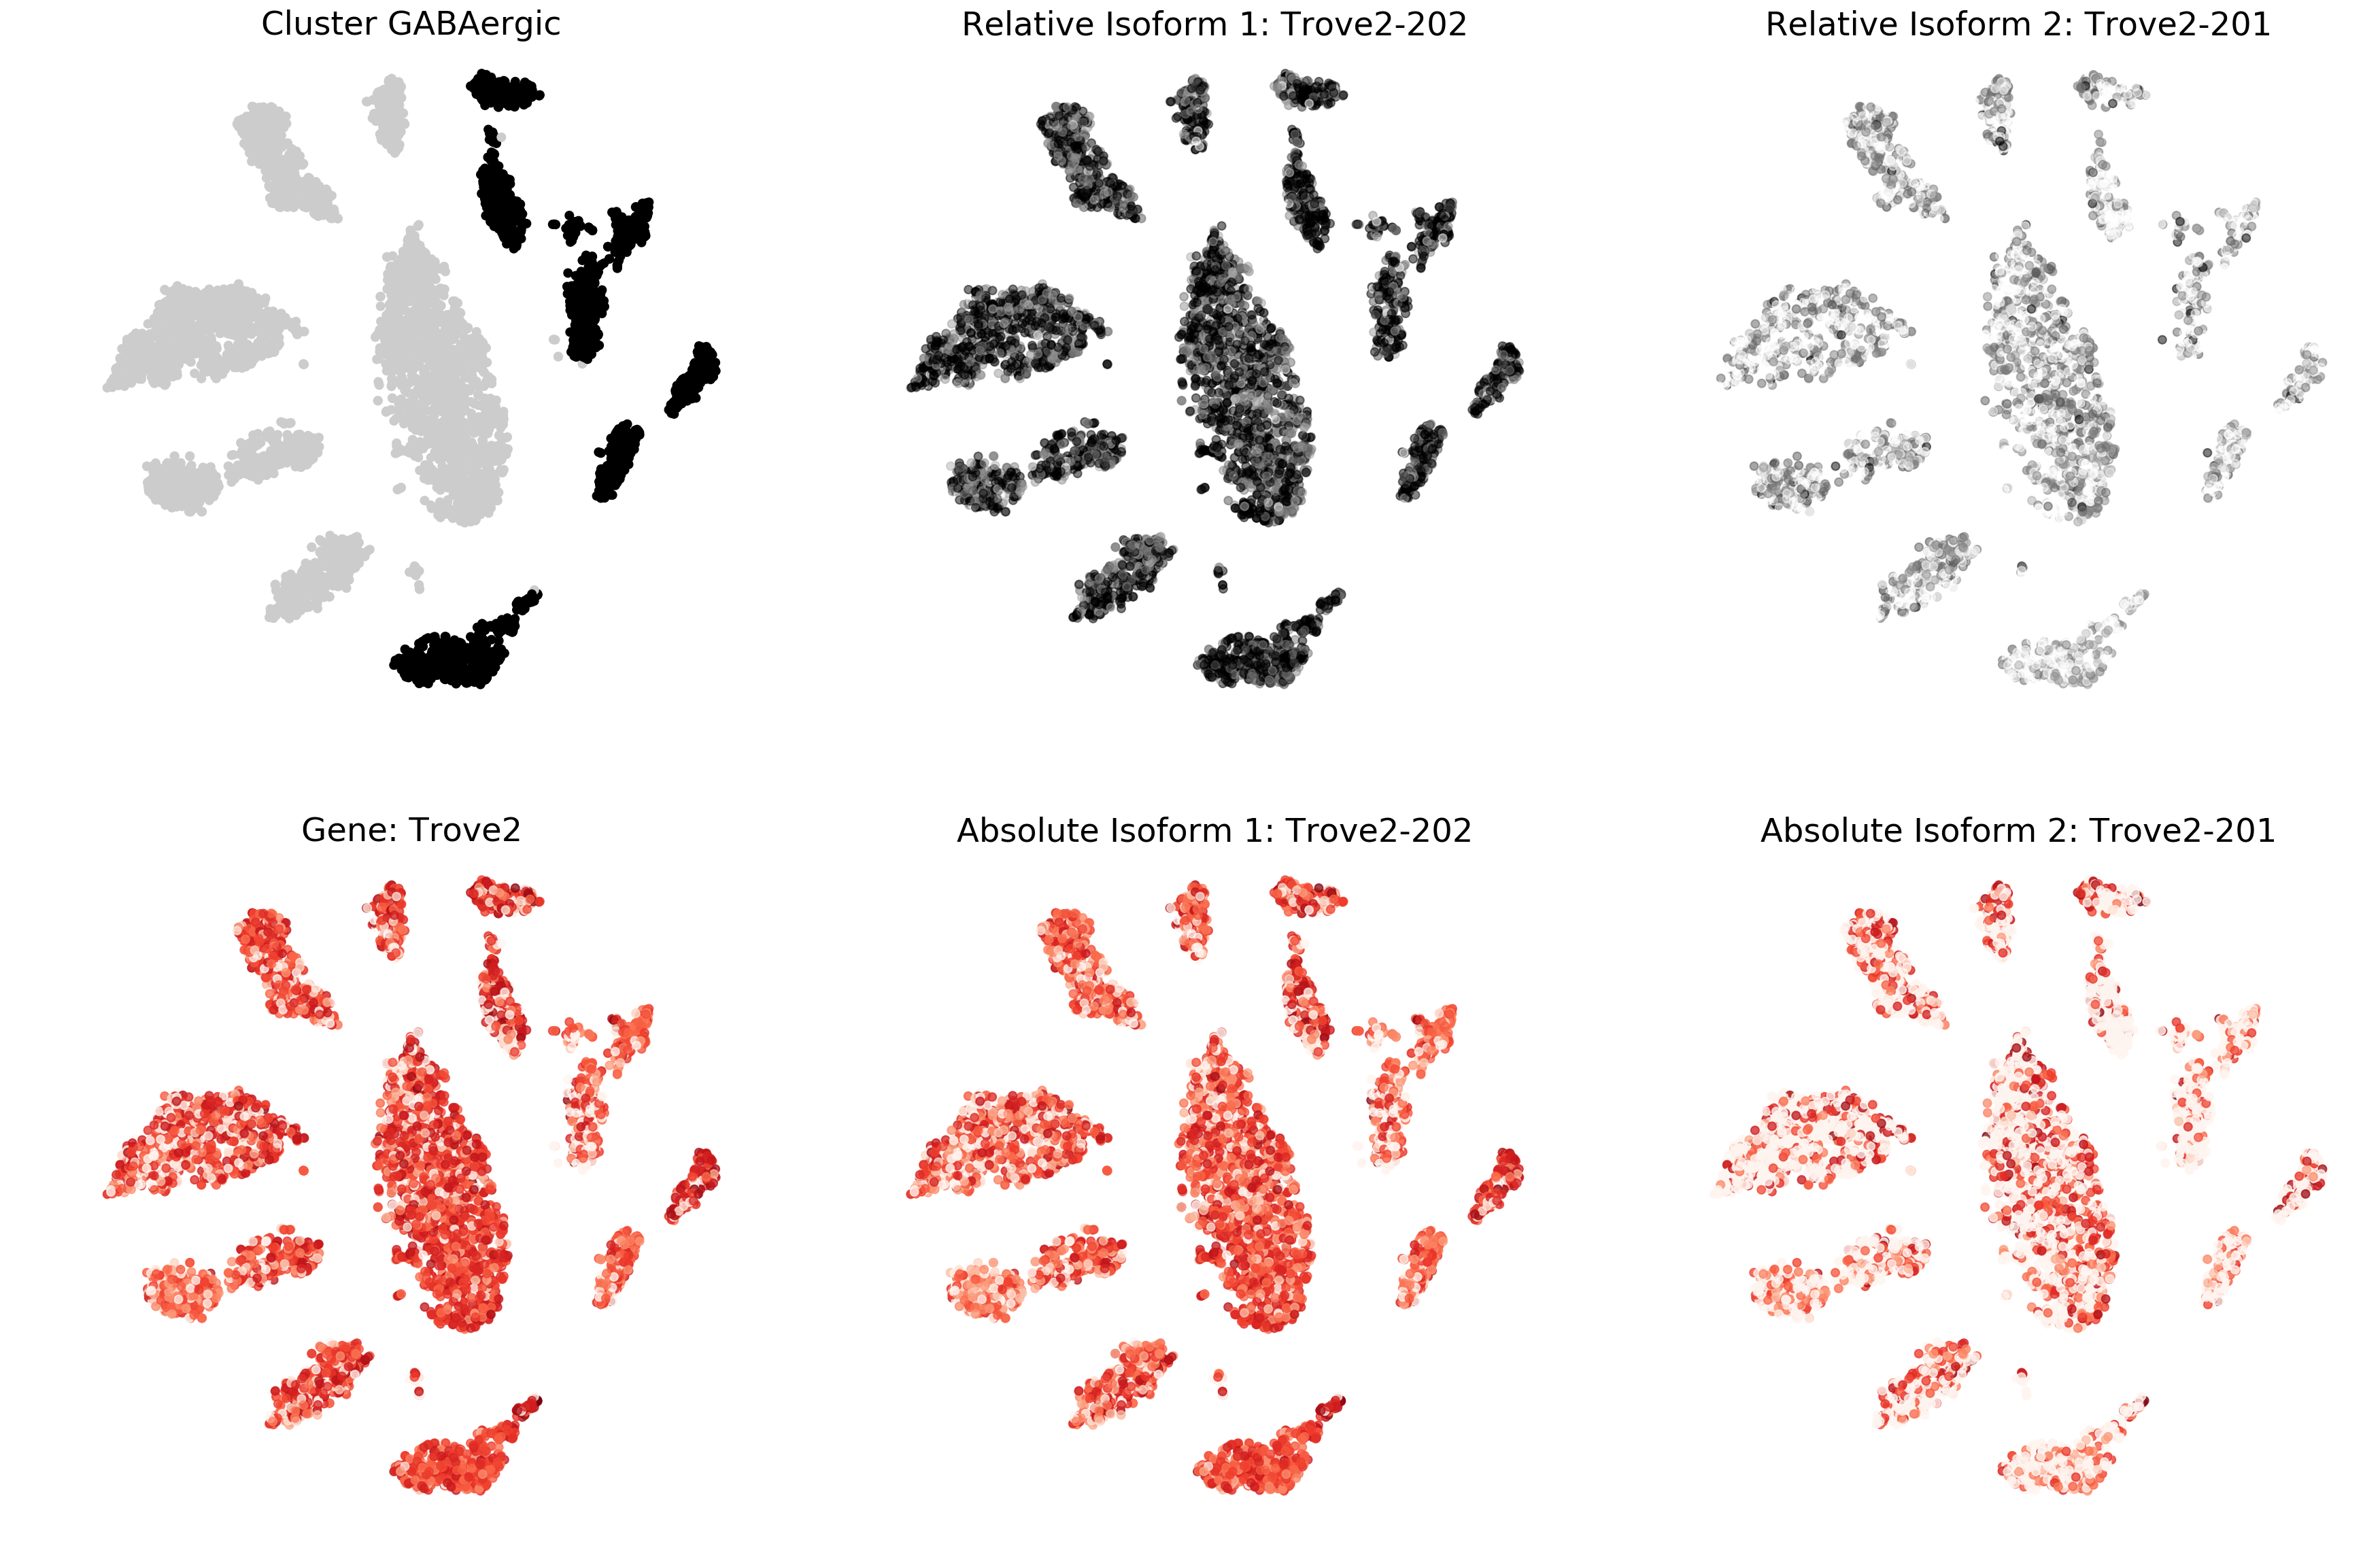

In [935]:
iso_1, iso_2 = isoform[:, isoform.var["gene_name"] == specific_gene].var.transcript_name.values


L1 = isof_exp.sum(axis=1)
norm = (isof_exp/L1[:,None])

fig, ax = plt.subplots(figsize=(30, 20), nrows=2, ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = assignments == specific_cluster
#cells = gene.obs["subclass_label"] == str(cidx)

loc = ax[0,0]
sc = loc.scatter(x, y, c = c, cmap="nipy_spectral_r")
loc.set_axis_off()
loc.set_title("Cluster {}".format(specific_cluster))

# Relative
loc = ax[0, 1]
c = norm[:,0]
idx = ~np.isnan(c)
sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
loc.set_axis_off()
loc.set_title("Relative Isoform 1: "+ iso_1)

loc = ax[0, 2]
c = norm[:,1]
idx = ~np.isnan(c)
sc = loc.scatter(x[idx], y[idx], c = c[idx], cmap="binary", alpha=0.5)
loc.scatter(x[~idx], y[~idx], color="white", alpha=0)
loc.set_axis_off()
loc.set_title("Relative Isoform 2: "+ iso_2)



cmap = "Reds"
# Gene Expression
loc = ax[1,0]
sc = loc.scatter(x, y, c = gene_exp, cmap=cmap, alpha=0.75)
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Gene: "+ specific_gene)


## Absolute
loc=ax[1, 1]
sc = loc.scatter(x, y, c = isof_exp[:,0], cmap=cmap, alpha=0.75)
loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Absolute Isoform 1: "+ iso_1)



loc=ax[1,2]
sc = loc.scatter(x, y, c = isof_exp[:,1], cmap=cmap, alpha=0.75)

loc.set_axis_off()
#cbar = fig.colorbar(sc, ax=loc, pad=0)
#cbar.set_ticks([])
loc.set_title("Absolute Isoform 2: "+ iso_2)



plt.show()